# Titanic Survival Prediction

## 1. Import Libraries and Load Data

First, let's import the necessary libraries and load our training and testing datasets.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 102.4+ KB


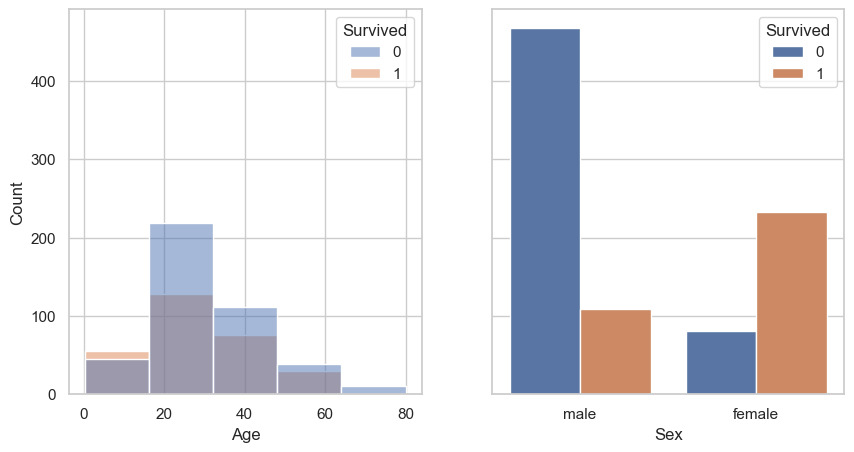

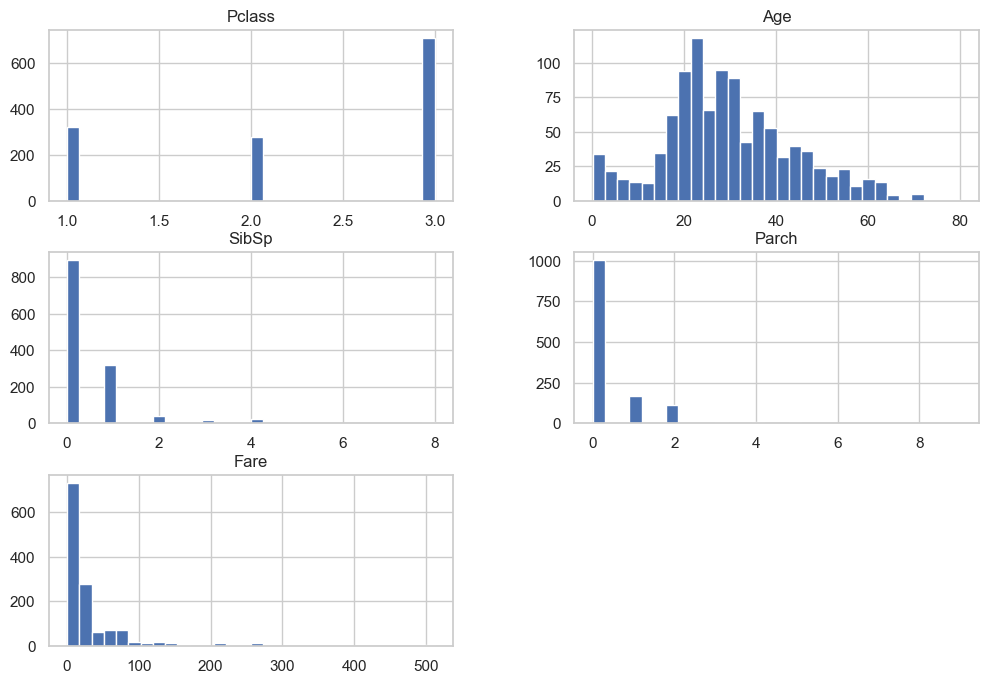

997
989


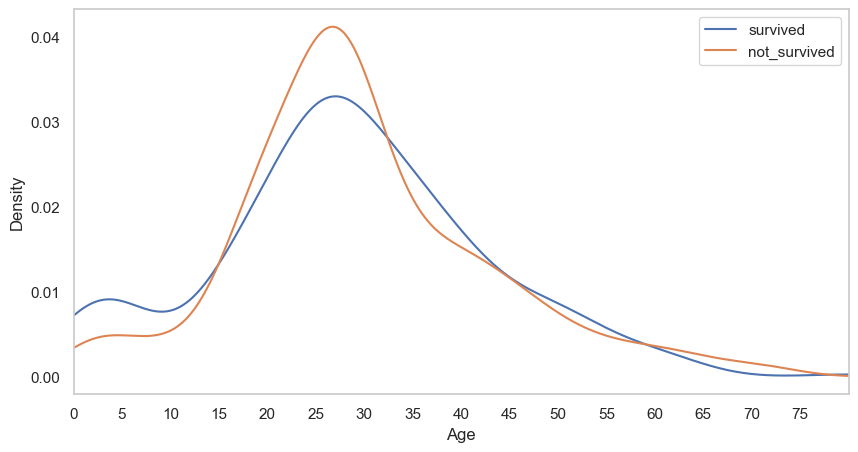

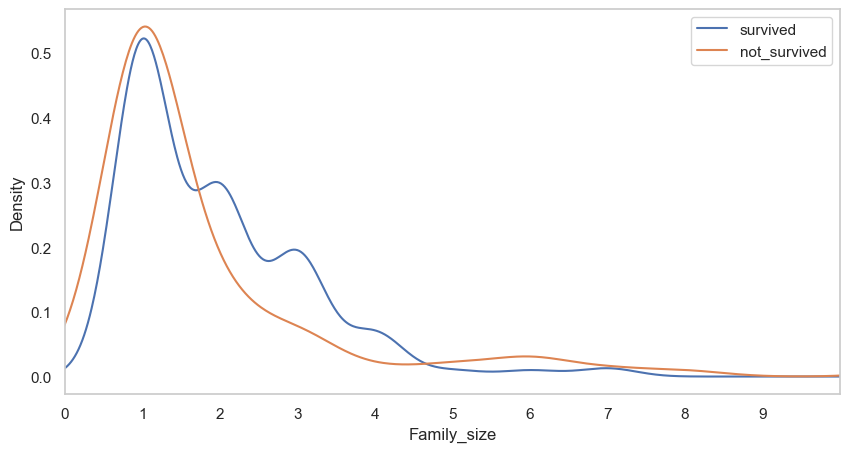

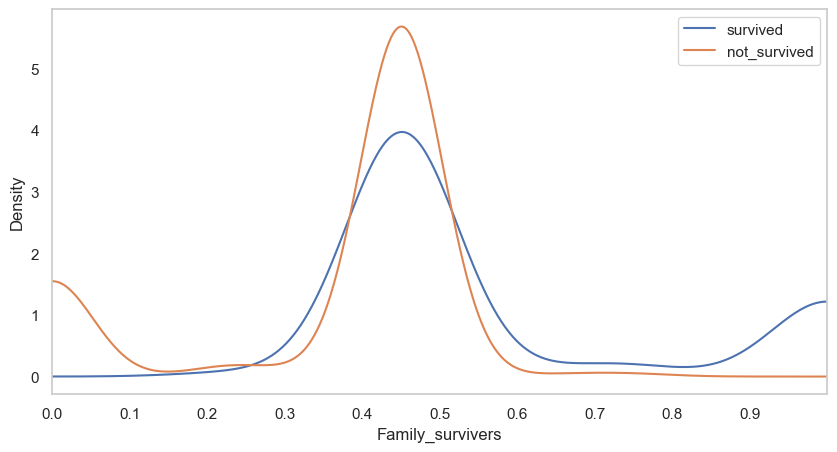

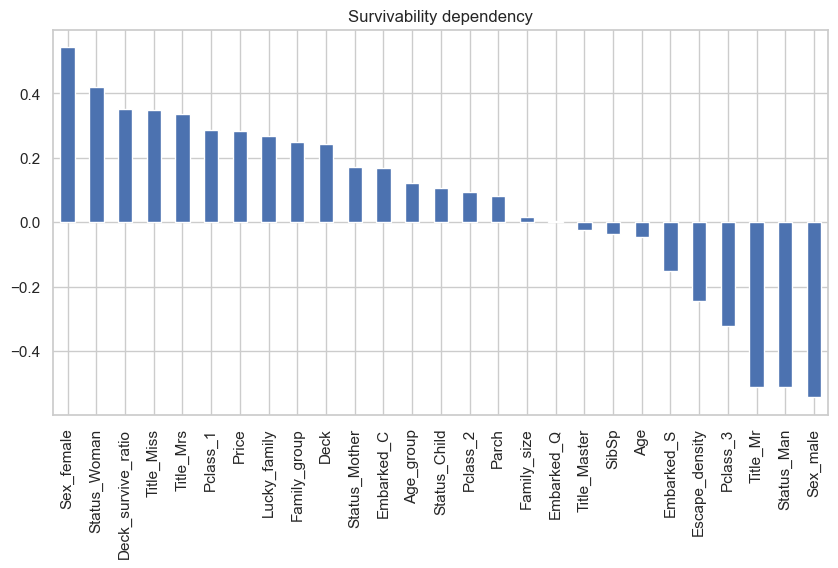

count    5.000000
mean     0.824945
std      0.017520
min      0.798883
25%      0.814607
50%      0.837079
75%      0.837079
max      0.837079
dtype: float64

             Feature Id  Importances
0         Lucky_family    23.504852
1             Sex_male    15.170032
2           Sex_female    13.904196
3             Title_Mr    11.333412
4           Status_Man     9.379041
5             Pclass_3     6.278832
6   Deck_survive_ratio     4.767186
7                Price     3.578620
8          Family_size     2.030147
9             Pclass_1     1.571889
10      Escape_density     1.392729
11                Deck     1.387674
12           Age_group     1.108085
13        Family_group     1.094339
14                 Age     0.999447
15               SibSp     0.884494
16            Pclass_2     0.395426
17               Parch     0.342392
18        Title_Master     0.314973
19        Status_Woman     0.176226
20        Status_Child     0.164247
21          Embarked_S     0.105921
22         

In [22]:
# ===================== 1) Import & Chargement des données ====================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import (SimpleImputer, IterativeImputer)
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.model_selection import (GridSearchCV, cross_val_score)
from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostClassifier

full_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
full_df.head()
test_pass_id = test_df.pop('PassengerId')

X_max_index = full_df.shape[0]
y = full_df.Survived

df = full_df.drop(['Survived', 'PassengerId'], axis=1)
df = pd.concat([df, test_df], axis=0).reset_index(drop=True)

# ===================== 2) EDA rapide (visuels légers) =======================
df.info()
corr = full_df.select_dtypes(include=['number']).corr()['Survived'].sort_values(ascending=False)
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(x='Age', hue='Survived', data=full_df, bins=5, ax=axs[0])
sns.countplot(x='Sex', hue='Survived', data=full_df, ax=axs[1])
plt.show()
df.hist(bins=30, figsize=(12, 8))
plt.show()

# ========== 3) Nettoyage & Feature Engineering (toutes features) =============
df.loc[df.Fare.eq(0), 'Fare'] = np.nan
df['Lastname'] = df.Name.str.split(', ').str[0]
df['Title'] = df.Name.str.split(', ').str[1]
df['Title'] = df.Title.str.split('.').str[0]

df.Title.value_counts()
df[df.Title.eq('Mr')].Age.describe()
df[df.Title.eq('Master')].Age.describe()
df[df.Title.eq('Mrs')].Age.describe()

mrs = ['Mrs', 'Mme']
df.loc[df.Title.isin(mrs), 'Title'] = 'Mrs'
miss = ['Ms', 'Miss', 'Mlle']
df.loc[df.Title.isin(miss), 'Title'] = 'Miss'
df.loc[(df.Title.eq('Mr') & df.Age.le(18)), 'Title'] = 'Master'
df.loc[(df.Title.eq('Mrs') & df.Age.le(18)), 'Title'] = 'Miss'
df.loc[(~df.Title.isin(['Mrs', 'Miss', 'Mr', 'Master']) & df.Sex.eq('male')), 'Title'] = 'Mr'
df.loc[(~df.Title.isin(['Mrs', 'Miss', 'Mr', 'Master']) & df.Sex.eq('female')), 'Title'] = 'Mrs'

df.loc[df.Age.le(18), 'Status'] = 'Child'
df.loc[df.Title.eq('Master'), 'Status'] = 'Child'
df.loc[(df.Title.eq('Mrs') & df.Parch.gt(0)), 'Status'] = 'Mother'
df.loc[(df.Status.isna() & df.Sex.eq('female')), 'Status'] = 'Woman'
df.loc[(df.Status.isna() & df.Sex.eq('male')), 'Status'] = 'Man'

df['Ticket_series'] = [i[0] if len(i) > 1 else 0 for i in df.Ticket.str.split()]
df['Ticket_nr'] = [i[-1] for i in df.Ticket.str.split()]

df_fare = df[~df.Fare.isna()]
multi_tickets = df_fare.groupby(df_fare.Ticket_nr[df_fare.Ticket_nr.duplicated()])
(multi_tickets.Fare.min() != multi_tickets.Fare.max()).sum()

ticket_dict = df.groupby('Ticket_nr').Lastname.count().to_dict()
df['Passengers_ticket'] = df.Ticket_nr.map(ticket_dict)
df['Price'] = (df.Fare / df.Passengers_ticket).round(1)

df['Deck'] = df.Cabin.str[0]
df.Deck.isna().sum()
df.groupby('Pclass').Deck.value_counts()
df.loc[df.Deck.isna(), 'Pclass'].value_counts()

def impute_deck_by(feature):
    for pclass in range(1, 4):
        map_dic = (df[~df.Deck.isna() & df.Pclass.eq(pclass)]
                   .groupby(feature).Deck.unique()
                   .apply(list).to_dict())
        map_dic = {i:j[0] for i, j in map_dic.items() if len(j) == 1}
        df.loc[df.Deck.isna() & df.Pclass.eq(pclass), 'Deck'] = df[feature].map(map_dic)
    print(df.Deck.isna().sum())

impute_deck_by('Ticket_nr')
impute_deck_by('Lastname')

full_df['Deck'] = full_df.Cabin.str[0]
deck_total_survived = full_df.groupby('Deck').Survived.sum()
deck_people = full_df.groupby('Deck').Deck.count()
deck_survived_dict = (deck_total_survived / deck_people).round(2).to_dict()
deck_nan_survived = full_df.loc[full_df.Deck.isna(), 'Survived']
deck_survived_dict['M'] = (deck_nan_survived.value_counts() / deck_nan_survived.count()).round(2)[1]

df['Deck_survive_ratio'] = df.Deck.fillna('M')
df.Deck_survive_ratio = df.Deck_survive_ratio.map(deck_survived_dict).astype('float')

df.groupby(['Pclass', 'Deck']).Price.describe()
df.loc[df.Deck.eq('T'), 'Deck'] = 'A'
df[df.Deck.eq('B')].sort_values('Price').head()
df.loc[(df.Deck.eq('B') & df.Price.lt(19)), 'Price'] = 19
df[df.Deck.eq('B')].sort_values('Price', ascending=False).head(10)
df.loc[(df.Deck.eq('B') & df.Price.gt(68)), 'Price'] = 68

class_deck_price = pd.DataFrame(df.groupby(['Pclass', 'Deck']).Price.mean().round(2)).reset_index()

for index, row in df.loc[df.Price.isna(), ['Pclass', 'Deck']].iterrows():
    if not pd.isna(row.Deck):
        new_price = class_deck_price.loc[
            (class_deck_price.Pclass.eq(row.Pclass) & class_deck_price.Deck.eq(row.Deck)), 'Price'
        ].mean()
    else:
        new_price = class_deck_price[class_deck_price.Pclass.eq(row.Pclass)].Price.mean()
    df.loc[[index], 'Price'] = new_price

first_cl = {'A': [25, 30], 'B': [35, 70], 'C': [30, 35], 'D': [19, 25], 'E': [9, 19]}
second_cl = {'D': [13, 17], 'E': [5, 9], 'F': [9, 13]}
third_cl = {'E': [8, 9], 'F': [9, 21], 'G': [0, 8]}
class_dict = {1: first_cl, 2: second_cl, 3: third_cl}

for index, row in df.loc[df.Deck.isna(), ['Pclass', 'Price']].iterrows():
    for c, d in class_dict.items():
        if row.Pclass == c:
            for i, j in d.items():
                if max(j) > row.Price >= min(j):
                    df.loc[[index], 'Deck'] = i

deck_level = {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7}
df.Deck = df.Deck.replace(deck_level)

deck_people = df.Deck.value_counts().sort_index()
deck_people_dic = deck_people.to_dict()
deck_people_dic
escape_density = {}
for i in range(1, 8):
    escape_density[i] = sum(deck_people_dic.values())
    del deck_people_dic[i]
escape_density
df['Escape_density'] = df.Deck.replace(escape_density)

df['Family_size'] = 1 + df.SibSp + df.Parch

X = df[:X_max_index].copy()
test_df = df[X_max_index:].copy()
full_df = pd.concat([X, y], axis=1).copy()

family_survivers = full_df[['Lastname', 'Survived']].groupby('Lastname').mean().round(2).reset_index()
family_survivers_dict = dict(zip(family_survivers.Lastname, family_survivers.Survived))
common_survivers = {}
for lastname, survived in family_survivers_dict.items():
    if lastname in list(test_df['Lastname'].unique()):
        common_survivers[lastname] = survived
df['Family_survivers'] = df.Lastname.map(common_survivers)
df.Family_survivers = df.Family_survivers.fillna(df.Family_survivers.mean())

df.Pclass = df.Pclass.astype('object')

col_drop = ['Name', 'Ticket', 'Ticket_nr', 'Ticket_series', 'Fare', 'Cabin', 'Lastname', 'Passengers_ticket']
df = df.drop(col_drop, axis=1)

categ_cols = list(df.select_dtypes(exclude=[np.number]).columns)
cat_imputer = SimpleImputer(strategy='most_frequent')
df_cat = pd.DataFrame(cat_imputer.fit_transform(df[categ_cols]), columns=df[categ_cols].columns)
df_cat = pd.get_dummies(df_cat)

num_cols = list(df.select_dtypes([np.number]).columns)
it_imp = IterativeImputer()
df_num = pd.DataFrame(it_imp.fit_transform(df[num_cols]), columns=df[num_cols].columns)

df = pd.concat([df_cat, df_num], axis=1)

X = df[:X_max_index]
full_df = pd.concat([X, y], axis=1)

def survive_chance_by(feature, xticks=None, xlim=None):
    survived = full_df[full_df.Survived.eq(1)]
    not_survived = full_df[full_df.Survived.eq(0)]
    plt.figure(figsize=(10, 5))
    survived[feature].plot(kind='kde', label='survived')
    not_survived[feature].plot(kind='kde', label='not_survived')
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.legend()
    plt.grid()
    plt.xlabel(feature)
    plt.show()

survive_chance_by('Age', np.arange(0, 80, 5), (0, 80))
df['Age_group'] = pd.cut(x=df.Age, labels=[5, 1, 4, 3, 2], bins=[-1, 15, 33, 45, 60, df.Age.max()]).astype('float')

survive_chance_by('Family_size', np.arange(0, 10, 1), (0, 10))
df['Family_group'] = pd.cut(x=df.Family_size, labels=[1, 3, 2], bins=[-1, 1, 4, df.Family_size.max()]).astype('float')

survive_chance_by('Family_survivers', np.arange(0, 1, 0.1), (0, 1))
df['Lucky_family'] = pd.cut(x=df.Family_survivers, labels=[2, 3, 1, 4],
                            bins=[-1, 0.22, 0.35, 0.49, df.Family_survivers.max()]).astype('float')

df.Price = df.Price.apply(np.log1p)
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df)
df = pd.DataFrame(df_scaled, columns=df.columns)
df = df.drop(['Family_survivers'], axis=1)

X = df[:X_max_index]
test_df = df[X_max_index:]
full_df = pd.concat([X, y], axis=1)

correlation = full_df.corr()['Survived'].sort_values(ascending=False)
correlation[1:].plot(kind='bar', figsize=(10,5), title='Survivability dependency')
plt.show()

# ============ 4) Entraînement modèle & évaluation (CatBoost CV) =============
# (Grille de recherche commentée dans la version d’origine)
cat_params = {'verbose': False, 'thread_count': -1, 'depth': 4, 'iterations': 1000, 'learning_rate': 0.0005}
cat_model = CatBoostClassifier(**cat_params)
cat_model.fit(X, y)

cat_rmses = cross_val_score(cat_model, X, y, cv=5)
print(pd.Series(cat_rmses).describe())
print('\n', cat_model.get_feature_importance(prettified=True))

# ==================== 5) Prédiction & fichier de soumission ==================
test_preds = cat_model.predict(test_df)
output = pd.DataFrame({'PassengerId': test_pass_id, 'Survived': test_preds})
output.to_csv('submission.csv', index=False)
